# Next day "close" predictor

В данной работе я буду обучать модель, которая будет предсказывать цену закрытия ценной бумаги на следующий день.
Данный предикт цены будет передан в блок принятия решений на основе рискового и финансового менеджмента.

В качестве данных мы возмем датасет с kaggle: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

#Импортируем вспомогательные инструменты
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

#Импортируем вспомогательные инструменты
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

#Импортируем инструменты для кодировки и предобработки
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from typing import List
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

#Импортируем необходимые инструменты SciPy и Stats
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.metrics import mean_absolute_error

#Импортируем метрики
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

#Импортируем инструменты для построения pipeline
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

import lightgbm as lgb

Для примера возьмем The Procter & Gamble (тикер на NYSE:PG)

## 1. Изучение данных

In [3]:
# Читаем данные
df = pd.read_csv("pg.us.txt", parse_dates=["Date"])

In [4]:
df.shape

(12075, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12075 non-null  datetime64[ns]
 1   Open     12075 non-null  float64       
 2   High     12075 non-null  float64       
 3   Low      12075 non-null  float64       
 4   Close    12075 non-null  float64       
 5   Volume   12075 non-null  int64         
 6   OpenInt  12075 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 660.5 KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,0
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,0
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,0
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,0


In [7]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
12070,2017-11-06,86.55,86.6400,86.03,86.05,5186619,0
12071,2017-11-07,86.04,87.0000,85.42,86.98,6874114,0
12072,2017-11-08,86.99,87.6000,86.80,87.58,6906479,0
12073,2017-11-09,87.35,88.1698,87.30,87.78,5279965,0
12074,2017-11-10,87.99,88.3900,87.78,88.16,7226148,0


In [8]:
df["OpenInt"].describe()

count    12075.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: OpenInt, dtype: float64

In [9]:
# Проверим максимальные и минимальные даты
df["Date"].min(), df["Date"].max()

(Timestamp('1970-01-02 00:00:00'), Timestamp('2017-11-10 00:00:00'))

<AxesSubplot:xlabel='Date'>

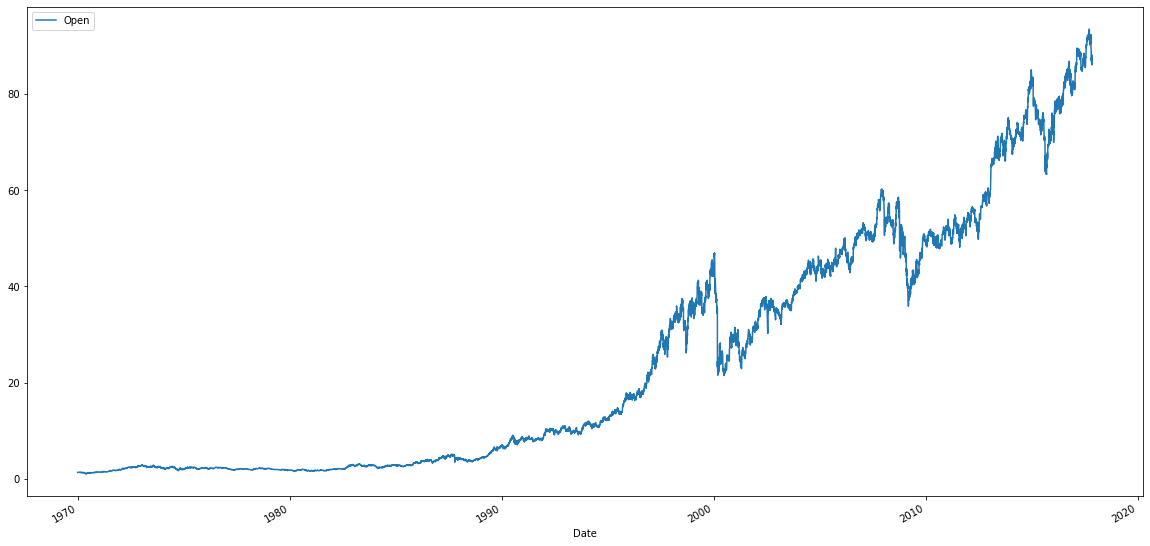

In [10]:
# Посмотрим на график открытий.
df.plot(x="Date", y="Open",figsize=(20,10))

У нас в датасете есть информация о ценах открытия/закрытия, минимума/максимума, проторгованный объем. Колонка открытого интереса пустая. На старте попробуем использовать такой простой набор данных. В последствии при помощи API получим дополнительные данные с торгового терминала.

На основе имеющегося графика можно сказать, что данная бумага интересна финансистам и инвесторам. Мы видим, что Бумага периодически переписывает свои исторические максимумы. Бумага не спускается на исторически-значимые минимумы во времена кризисов (перед 2000 и 2008).Следовательно во времена кризисов её держат, а в "хорошие" времена в нее привлекают инвесторов.

На основе графика можно сказать, что у нас в целом в компании есть некий тренд. Обусловлен как инфляцией, развитием компании и вливаниям капиталов. Поэтому в решении мы будем использовать подход с временными рядами. В данном ноутбуке мы попробуем LightGBM. А в другой тетрадке я попробую обучить нейросеть.

In [11]:
# Проверим корреляцию 
df[["Open", "Close", "Low", "High"]].corr()

,Open,Close,Low,High
Open,1.000000,0.999907,0.999920,0.999947
Close,0.999907,1.000000,0.999926,0.999953
Low,0.999920,0.999926,1.000000,0.999889
High,0.999947,0.999953,0.999889,1.000000


Из анализа "головы" и "хвоста" можно увидеть, что объмы в 1970 и 2017 года отличаются примерно в 10 раз. Поэтому для обучения возьмем только актуальные данные за последние несколько лет. Однако важно, чтобы в выборку попал период спада. Из графика видим, что если мы возьмем 7 лет, спад попадет в выборку.

In [12]:
df_7 = df[df["Date"] > df["Date"].max() - timedelta(days=365 * 7.2)]

In [13]:
df_7.shape

(1813, 7)

In [14]:
# Проверим максимальные и минимальные даты
df_7["Date"].min(), df_7["Date"].max()

(Timestamp('2010-09-01 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [15]:
df_7.head(15)

,Date,Open,High,Low,Close,Volume,OpenInt
10262,2010-09-01,48.303,48.447,48.026,48.243,18281466,0
10263,2010-09-02,48.197,48.647,48.173,48.462,12714548,0
10264,2010-09-03,48.682,48.810,48.266,48.639,11118652,0
10265,2010-09-07,48.414,48.769,48.341,48.518,9197970,0
10266,2010-09-08,48.526,48.810,48.526,48.705,9568414,0
10267,2010-09-09,48.946,48.961,48.577,48.639,9838673,0
10268,2010-09-10,48.817,48.915,48.631,48.727,9145890,0
10269,2010-09-13,48.931,49.003,48.583,48.794,12154837,0
10270,2010-09-14,48.719,49.164,48.664,48.924,13648677,0
10271,2010-09-15,48.856,49.543,48.832,49.300,11384616,0


In [16]:
#Используем столбец datetime в качестве индекса
df_7=df_7.set_index(['Date'])

#Отсортируем данные
df_7.sort_index(inplace=True)

#Проверим
df_7.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-09-01,48.303,48.447,48.026,48.243,18281466,0
2010-09-02,48.197,48.647,48.173,48.462,12714548,0
2010-09-03,48.682,48.810,48.266,48.639,11118652,0
2010-09-07,48.414,48.769,48.341,48.518,9197970,0
2010-09-08,48.526,48.810,48.526,48.705,9568414,0


In [17]:
searcher = df_7.copy()

In [18]:
searcher = searcher[["Close"]]

In [19]:
searcher

,Close
Date,
2010-09-01,48.243
2010-09-02,48.462
2010-09-03,48.639
2010-09-07,48.518
2010-09-08,48.705
...,...
2017-11-06,86.050
2017-11-07,86.980
2017-11-08,87.580


<AxesSubplot:xlabel='Date'>

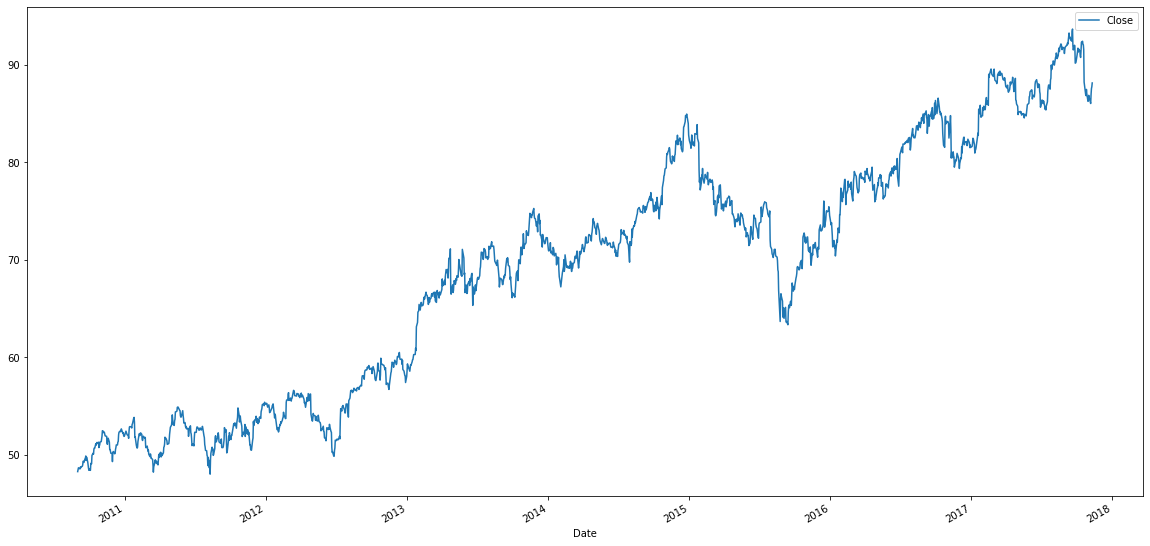

In [20]:
#Вглянем на наш временной ряд
searcher.plot(figsize=(20,10))

## 2. Инжиниринг

In [21]:
def make_features(df, max_lag, rolling_mean_size):
    '''
    input:
    
        df - DataFrameObject - Исследуемый фрейм
    
        max_lag - int - количество лаг(фич) которое необходимо добавить со смещением в 1 шаг 
            
        rollling_mean_size - int - количество интервалов для усреднения
    
    Данная функция генерирует дополнительные фичи с опорой на математику временных рядов.
    Добавляет фичи дня недели, лаги смещения, скользящую среднюю.
    
    '''
    
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['Close'].shift(lag)

    df['rolling_mean'] = df['Close'].shift().rolling(rolling_mean_size).mean()
    
    print('Строка документации: \n', make_features.__doc__)   

In [22]:
# Создадим признаки
make_features(df_7, 2, 23)
df_7=df_7.dropna()

Строка документации: 
 
    input:
    
        df - DataFrameObject - Исследуемый фрейм
    
        max_lag - int - количество лаг(фич) которое необходимо добавить со смещением в 1 шаг 
            
        rollling_mean_size - int - количество интервалов для усреднения
    
    Данная функция генерирует дополнительные фичи с опорой на математику временных рядов.
    Добавляет фичи дня недели, лаги смещения, скользящую среднюю.
    
    


Итак, нам необходимо создать кастомный датасет. Нам необходимо предсказывать цену закрытия продолжим генерировать признаки.

1) В качестве фичей будем использовать цены открытия и закрытия предыдущих дней.

2) На рынке ценных бумаг существуют гэпы. Их будем вычислять вычитая из цены открытия текущего дня цены закрытия предыдущего.

3) Объем оставим без изменений (В будущем это признак можно будет изучить более подробно).

4) Торговый диапазон предыдущих дней будем будем высчитывать вычитая High-Low. 

5) Построим категориальный признак падающего или растущего дня, если открытие выше закрытия вернем 0, если нет 1.

In [23]:
test = df_7.copy()

In [24]:
test=test.reset_index()

In [25]:
test.head()

,Date,Open,High,Low,Close,Volume,OpenInt,dayofweek,lag_1,lag_2,rolling_mean
0,2010-10-05,48.639,49.142,48.397,49.065,14129153,0,1,48.371,48.534,48.940870
1,2010-10-06,49.029,49.204,48.647,49.106,8961400,0,2,49.065,48.371,48.976609
2,2010-10-07,49.237,49.326,49.012,49.051,28826108,0,3,49.106,49.065,49.004609
3,2010-10-08,49.212,50.019,49.134,49.907,19727129,0,4,49.051,49.106,49.022522
4,2010-10-11,49.954,50.189,49.907,50.131,9203607,0,0,49.907,49.051,49.082913


In [26]:
test.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,dayofweek,lag_1,lag_2,rolling_mean
1785,2017-11-06,86.55,86.6400,86.03,86.05,5186619,0,0,86.58,86.51,89.410261
1786,2017-11-07,86.04,87.0000,85.42,86.98,6874114,0,1,86.05,86.58,89.163174
1787,2017-11-08,86.99,87.6000,86.80,87.58,6906479,0,2,86.98,86.05,88.973348
1788,2017-11-09,87.35,88.1698,87.30,87.78,5279965,0,3,87.58,86.98,88.796696
1789,2017-11-10,87.99,88.3900,87.78,88.16,7226148,0,4,87.78,87.58,88.637783


In [27]:
target = test[["Close"]]

In [28]:
open_price = test[["Open"]]

Начнем добавлять признаки открытия цены 

In [29]:
open_price = open_price.iloc[1:].reset_index().drop("index", axis=1)

In [30]:
target = target.iloc[1:].reset_index().drop("index", axis=1)

In [31]:
test["target"] = target

In [32]:
test["open_price"] = open_price

In [33]:
# Считаем разброс цены дня
test["day_variance"] = test["High"]-test["Low"]

In [34]:
# Cчитаем Гэп
test["gap"] = test["open_price"]-test["Close"]

In [35]:
# Пишем функцию определния растущего/падающего дня
def short_long(row):
    
    op = row["Open"]
    cl = row["Close"]
    
    if op>cl:
        return 0
    else:
        return 1

In [36]:
# Применяем
test["sh_l"]=test.apply(short_long, axis=1)

In [37]:
test.head()

,Date,Open,High,Low,Close,Volume,OpenInt,dayofweek,lag_1,lag_2,rolling_mean,target,open_price,day_variance,gap,sh_l
0,2010-10-05,48.639,49.142,48.397,49.065,14129153,0,1,48.371,48.534,48.940870,49.106,49.029,0.745,-0.036,1
1,2010-10-06,49.029,49.204,48.647,49.106,8961400,0,2,49.065,48.371,48.976609,49.051,49.237,0.557,0.131,1
2,2010-10-07,49.237,49.326,49.012,49.051,28826108,0,3,49.106,49.065,49.004609,49.907,49.212,0.314,0.161,0
3,2010-10-08,49.212,50.019,49.134,49.907,19727129,0,4,49.051,49.106,49.022522,50.131,49.954,0.885,0.047,1
4,2010-10-11,49.954,50.189,49.907,50.131,9203607,0,0,49.907,49.051,49.082913,50.037,50.028,0.282,-0.103,1


In [38]:
test.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'dayofweek', 'lag_1', 'lag_2', 'rolling_mean', 'target', 'open_price',
       'day_variance', 'gap', 'sh_l'],
      dtype='object')

In [39]:
test=test.set_index("Date")

In [40]:
test = test[['Open', 'Close', 'Volume', 'day_variance', 'gap', 'sh_l', 'rolling_mean', 
             'dayofweek', 'lag_1', 'lag_2','target']]

In [41]:
test = test.dropna()

Text(0.5, 1.0, 'Correlation Heatmap')

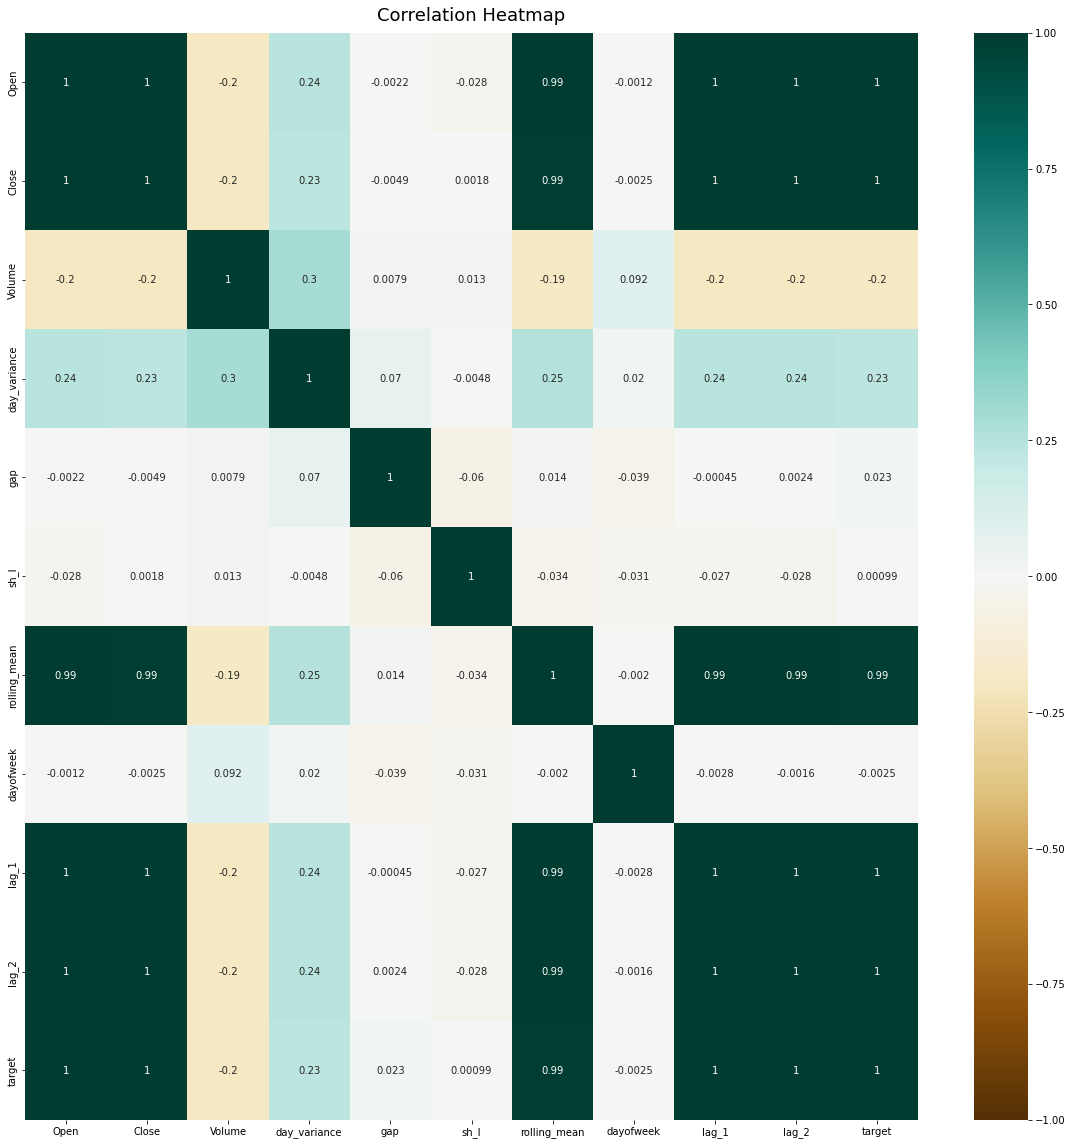

In [42]:
#Построим correlation heatmap
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(test.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Можно заметить, что Вчерашние цены открытия и закрытия коррелируют с таргетом, один из признаков уберем (Открытие). Так же имеет смысле избавиться от одного из Лага (lag_1).

In [43]:
test = test.drop(["Open", "lag_1"], axis=1)

In [44]:
test.head()

,Close,Volume,day_variance,gap,sh_l,rolling_mean,dayofweek,lag_2,target
Date,,,,,,,,,
2010-10-05,49.065,14129153,0.745,-0.036,1,48.940870,1,48.534,49.106
2010-10-06,49.106,8961400,0.557,0.131,1,48.976609,2,48.371,49.051
2010-10-07,49.051,28826108,0.314,0.161,0,49.004609,3,49.065,49.907
2010-10-08,49.907,19727129,0.885,0.047,1,49.022522,4,49.106,50.131
2010-10-11,50.131,9203607,0.282,-0.103,1,49.082913,0,49.051,50.037


## 3. Предобработка и обучение

In [47]:
# Создадим класс селектор при помощи которого будем выбирать необходимые столбцы для обработки
class FeatureSelector(BaseEstimator, TransformerMixin):
    '''
    Данный класс извлекает и возвращает набор данных с теми столбцами,
    имена которых были переданы в качестве аргумента при инициализации
    '''
  
  #Инициализируем класс
    def __init__(self, feature_names):
        self._feature_names = feature_names 
  
  #Поставим заглушку
    def fit(self, X, y = None):
        return self 

  #Вывод набора данных
    def transform(self, X, y = None):
        return X[self._feature_names].values 

print('Строка документации: \n', FeatureSelector.__doc__)   

Строка документации: 
 
    Данный класс извлекает и возвращает набор данных с теми столбцами,
    имена которых были переданы в качестве аргумента при инициализации
    


In [48]:
#Создадим фреймы с целевой переменной и признаками:
y = test['target']
X = test.drop(['target'], axis=1)

In [49]:
X.columns

Index(['Close', 'Volume', 'day_variance', 'gap', 'sh_l', 'rolling_mean',
       'dayofweek', 'lag_2'],
      dtype='object')

In [50]:
#Cоздадим лист категориальных признаков
cuts = ['sh_l', 'dayofweek']
qty_cuts = len(cuts)
print(qty_cuts, ' Categorical features:', cuts)

#Создадим список количественных признаков    
nums = ['Close', 'Volume', 'day_variance', 'gap', 'rolling_mean', 'lag_2']
qty_nums = len(nums)
print(qty_nums, ' Numerical features:', nums)

2  Categorical features: ['sh_l', 'dayofweek']
6  Numerical features: ['Close', 'Volume', 'day_variance', 'gap', 'rolling_mean', 'lag_2']


In [51]:
# Строим pipeline для категориальных признаков
categorical_pipeline=Pipeline(steps=[('cat_selector', FeatureSelector(cuts)),
                                     ('impute', SimpleImputer(strategy = 'most_frequent')),
                                     ('one_hot_encoder', OrdinalEncoder())]) 

#Строим pipeline для числовых признаков
numerical_pipeline=Pipeline(steps=[('cat_selector', FeatureSelector(nums)),
                                   ( 'impute', SimpleImputer(strategy='mean')),
                                    ('std_scaler', StandardScaler())])  

#Объединяем
all_features=FeatureUnion(transformer_list=[('categorical_pipeline', categorical_pipeline), 
                                            ('numerical_pipeline', numerical_pipeline)]) 

In [52]:
#Разделим выборки на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 1123, shuffle=False)

In [53]:
#Прогоняем данные через pipeline
X_train=all_features.fit_transform(X_train)
X_test=all_features.fit_transform(X_test)

In [54]:
# Напишем функцию для метрики RMSE
def root_mse(y, y_pred):
    return(mean_squared_error(y, y_pred))**0.5

In [55]:
#Создадим метрику
rmse=make_scorer(root_mse, greater_is_better=False)

In [56]:
#Создадим лист с категориальными признаками
cat_feature=[0,1]

In [57]:
#Найдем наилучшие гиперпараметры LightGBM, используя GridSearch
params = {
    'num_leaves': list(range(2,20, 2)),
    'max_depth': list(range(2,20, 2)),
    'n_estimators': list(range(1,500, 50))
}

scv = TimeSeriesSplit(n_splits=20)

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0, categorical_feature=cat_feature), params, scoring=rmse, cv=scv)
best_LGBMR=grid.fit(X_train, y_train)

print('Лучшие параметры (CV rmse score =%0.3f):' % best_LGBMR.best_score_)

print("Лучшая модель:\n", best_LGBMR.best_params_)

Лучшие параметры (CV rmse score =-1.314):
Лучшая модель:
 {'max_depth': 14, 'n_estimators': 451, 'num_leaves': 16}


In [58]:
# Инициализируем лучшую модель
best_params={'num_leaves': 16,
             'max_depth': 14,
             'n_estimators': 451}

lgbm_model=lgb.LGBMRegressor(**best_params)

In [59]:
# Учим модель
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], categorical_feature=cat_feature)

[1]	valid_0's l2: 415.559
[2]	valid_0's l2: 409.822
[3]	valid_0's l2: 405.698
[4]	valid_0's l2: 403.398
[5]	valid_0's l2: 402.295
[6]	valid_0's l2: 401.151
[7]	valid_0's l2: 400.89
[8]	valid_0's l2: 401.037
[9]	valid_0's l2: 401.811
[10]	valid_0's l2: 402.557
[11]	valid_0's l2: 403.391
[12]	valid_0's l2: 404.125
[13]	valid_0's l2: 405.481
[14]	valid_0's l2: 406.759
[15]	valid_0's l2: 407.861
[16]	valid_0's l2: 409.089
[17]	valid_0's l2: 410.267
[18]	valid_0's l2: 411.211
[19]	valid_0's l2: 412.04
[20]	valid_0's l2: 413.129
[21]	valid_0's l2: 414.111
[22]	valid_0's l2: 414.983
[23]	valid_0's l2: 415.634
[24]	valid_0's l2: 416.656
[25]	valid_0's l2: 417.253
[26]	valid_0's l2: 418.004
[27]	valid_0's l2: 418.571
[28]	valid_0's l2: 418.948
[29]	valid_0's l2: 419.5
[30]	valid_0's l2: 419.958
[31]	valid_0's l2: 420.478
[32]	valid_0's l2: 420.715
[33]	valid_0's l2: 421.119
[34]	valid_0's l2: 421.509
[35]	valid_0's l2: 421.808
[36]	valid_0's l2: 422.083
[37]	valid_0's l2: 422.331
[38]	valid_0's

[349]	valid_0's l2: 425.762
[350]	valid_0's l2: 425.765
[351]	valid_0's l2: 425.77
[352]	valid_0's l2: 425.779
[353]	valid_0's l2: 425.771
[354]	valid_0's l2: 425.766
[355]	valid_0's l2: 425.765
[356]	valid_0's l2: 425.76
[357]	valid_0's l2: 425.748
[358]	valid_0's l2: 425.741
[359]	valid_0's l2: 425.755
[360]	valid_0's l2: 425.733
[361]	valid_0's l2: 425.764
[362]	valid_0's l2: 425.785
[363]	valid_0's l2: 425.777
[364]	valid_0's l2: 425.77
[365]	valid_0's l2: 425.755
[366]	valid_0's l2: 425.751
[367]	valid_0's l2: 425.738
[368]	valid_0's l2: 425.714
[369]	valid_0's l2: 425.707
[370]	valid_0's l2: 425.704
[371]	valid_0's l2: 425.705
[372]	valid_0's l2: 425.712
[373]	valid_0's l2: 425.725
[374]	valid_0's l2: 425.717
[375]	valid_0's l2: 425.722
[376]	valid_0's l2: 425.717
[377]	valid_0's l2: 425.711
[378]	valid_0's l2: 425.71
[379]	valid_0's l2: 425.676
[380]	valid_0's l2: 425.674
[381]	valid_0's l2: 425.685
[382]	valid_0's l2: 425.69
[383]	valid_0's l2: 425.686
[384]	valid_0's l2: 425.6

LGBMRegressor(max_depth=14, n_estimators=451, num_leaves=16)

In [60]:
y_pred_train=lgbm_model.predict(X_train)

In [61]:
y_pred_test=lgbm_model.predict(X_test)

In [62]:
print('RMSE лучшей модели на тренировочной выборке= %0.3f:' %root_mse(y_train, y_pred_train))
print('RMSE лучшей модели на тестовой выборке= %0.3f:' %root_mse(y_test, y_pred_test))

RMSE лучшей модели на тренировочной выборке= 0.173:
RMSE лучшей модели на тестовой выборке= 20.633:


Text(0, 0.5, 'Цена')

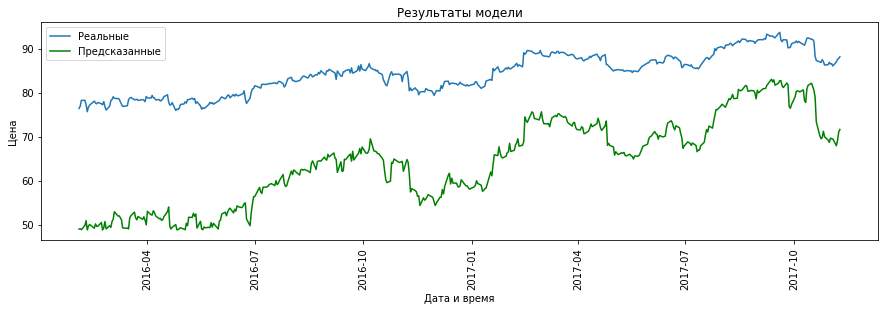

In [63]:
predictions = pd.Series(y_pred_test)
predictions.index = y_test.index

fig2, ax = plt.subplots(figsize=(15, 4))
ax = sns.lineplot(data=y_test, label='Реальные')
sns.lineplot(data=predictions, color='green', label='Предсказанные')
plt.xticks(rotation=90)
plt.title('Результаты модели')
plt.xlabel('Дата и время')
plt.ylabel('Цена')

# Вывод:
Мы обучили модель используя LGBM. Слишком великая разница между реальными данными и предсказанными. Попробуем в другой тетради обучить нейронную сеть.